In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc # garbage collection module to release memory usage in time
import time
import warnings

In [28]:
os.chdir('/Users/Dorothy/Downloads/datashare')
warnings.filterwarnings('ignore')
%matplotlib inline

In [29]:
%%time
# start date and end date of the sample
stdt, nddt = 20010101, 20201231



# load firm characteristics data
data_ch = pd.read_csv('GKX_20201231.csv')
data_ch = data_ch[(data_ch['DATE']>=stdt)&(data_ch['DATE']<=nddt)].reset_index(drop=True)
data_ch['DATE'] = pd.to_datetime(data_ch['DATE'],format='%Y%m%d')+pd.offsets.MonthEnd(0)
characteristics = list(set(data_ch.columns).difference({'permno','DATE','SHROUT','mve0','sic2','RET','prc'}))


data_ch.head()

CPU times: total: 45.6 s
Wall time: 1min 13s


,permno,DATE,mvel1,RET,prc,SHROUT,beta,betasq,chmom,dolvol,...,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,bm,bm_ia
0,10001,2001-01-31,24355.500,0.012821,9.8750,2498,0.037079,0.001375,0.281788,8.395576,...,0.020711,1.098587e-06,0.027778,0.017710,0.972710,0.426715,4.200000e+00,49.0,0.868139,-0.104925
1,10002,2001-01-31,78332.625,0.088435,10.0000,8526,0.206346,0.042579,0.050021,8.067022,...,0.033991,6.509871e-06,0.134328,0.054790,1.368962,0.759666,4.200000e+00,60.0,0.680296,-0.152630
2,10012,2001-01-31,39836.000,0.500000,3.0000,20897,2.470629,6.104008,-1.170178,11.360419,...,0.138777,9.482216e-08,0.129412,0.075671,0.465917,7.007556,8.756593e-09,36.0,0.061049,-0.397365
3,10016,2001-01-31,379569.500,0.030726,23.0625,16964,0.449866,0.202379,0.391222,12.024414,...,0.054578,5.643552e-08,0.070769,0.040708,1.242227,8.102766,1.833562e-08,38.0,0.287808,-0.227582
4,10019,2001-01-31,28945.000,0.071429,3.7500,8270,2.249729,5.061279,0.203106,9.294773,...,0.131620,3.206363e-07,0.435897,0.120324,0.983488,16.163956,7.497863e-09,38.0,0.552262,0.036872


In [30]:
data_ch_top = data_ch.sort_values('mvel1',ascending=False).groupby('DATE').head(1000).reset_index(drop=True)
data_ch_bot = data_ch.sort_values('mvel1',ascending=False).groupby('DATE').tail(1000).reset_index(drop=True)

In [31]:
data_ch.isnull().sum()

permno            0
DATE              0
mvel1           276
RET               0
prc            7830
              ...  
std_turn        410
zerotrade       342
sic2          22532
bm           375825
bm_ia        375825
Length: 101, dtype: int64

In [32]:
%%time
# fill na with cross-sectional median
for ch in characteristics:
     data_ch[ch] = data_ch.groupby('DATE')[ch].transform(lambda x: x.fillna(x.median()))

CPU times: total: 16.6 s
Wall time: 17.7 s


In [33]:
# missing data after filling
data_ch.isnull().sum()

permno            0
DATE              0
mvel1             0
RET               0
prc            7830
              ...  
std_turn          0
zerotrade         0
sic2          22532
bm           104764
bm_ia        104764
Length: 101, dtype: int64

In [34]:
for ch in characteristics:
     data_ch[ch] = data_ch[ch].fillna(0)

data_ch.columns[data_ch.isnull().sum()!=0]

Index(['prc', 'mve0', 'sic2'], dtype='object')

In [35]:
def fill_na(data_ch, characteristics):
    for ch in characteristics:
         data_ch[ch] = data_ch.groupby('DATE')[ch].transform(lambda x: x.fillna(x.median()))
    for ch in characteristics:
         data_ch[ch] = data_ch[ch].fillna(0)
    return data_ch
data_ch_top = fill_na(data_ch_top, characteristics)
data_ch_bot = fill_na(data_ch_bot, characteristics)

Transform SIC Code into Dummies

In [36]:
# get dummies for SIC code
def get_sic_dummies(data_ch):
    sic_dummies = pd.get_dummies(data_ch['sic2'].fillna(999).astype(int),prefix='sic').drop('sic_999',axis=1)
    data_ch_d = pd.concat([data_ch,sic_dummies],axis=1)
    data_ch_d.drop(['prc','SHROUT','mve0','sic2'],inplace=True,axis=1)
    return data_ch_d
data_ch_d = get_sic_dummies(data_ch)
data_ch_top_d = get_sic_dummies(data_ch_top)
data_ch_bot_d = get_sic_dummies(data_ch_bot)

Macroeconomic Predictors Data

In [37]:
# load macroeconomic predictors data
data_ma = pd.read_csv('PredictorData2022.csv')
data_ma = data_ma[(data_ma['yyyymm']>=stdt//100)&(data_ma['yyyymm']<=nddt//100)].reset_index(drop=True)

# construct predictor
ma_predictors = ['dp_sp','ep_sp','bm_sp','ntis','tbl','tms','dfy','svar']
data_ma['Index'] = data_ma['Index'].str.replace(',','').astype('float64')
data_ma['dp_sp'] = data_ma['D12']/data_ma['Index']
data_ma['ep_sp'] = data_ma['E12']/data_ma['Index']
data_ma.rename({'b/m':'bm_sp'},axis=1,inplace=True)
data_ma['tms'] = data_ma['lty']-data_ma['tbl']
data_ma['dfy'] = data_ma['BAA']-data_ma['AAA']
data_ma = data_ma[['yyyymm']+ma_predictors]
data_ma['yyyymm'] = pd.to_datetime(data_ma['yyyymm'],format='%Y%m')+pd.offsets.MonthEnd(0)
data_ma.head()

,yyyymm,dp_sp,ep_sp,bm_sp,ntis,tbl,tms,dfy,svar
0,2001-01-31,0.011839,0.035490,0.150450,-0.003193,0.0515,0.0047,0.0078,0.004941
1,2001-02-28,0.012962,0.037873,0.156070,-0.006856,0.0488,0.0061,0.0077,0.002528
2,2001-03-31,0.013766,0.039161,0.133114,-0.005213,0.0442,0.0117,0.0086,0.007140
3,2001-04-30,0.012707,0.034060,0.122497,-0.002543,0.0387,0.0206,0.0087,0.007426
4,2001-05-31,0.012567,0.031592,0.120510,-0.000248,0.0362,0.0232,0.0078,0.002536


Construct the Dataset including all the Features

In [38]:
from sklearn.preprocessing import MinMaxScaler

def interactions(data_ch, data_ma, characteristics, ma_predictors, minmax=True):
    # construct interactions between firm characteristics and macroeconomic predictors
    data = data_ch.copy()
    data_ma_long = pd.merge(data[['DATE']],data_ma,left_on='DATE',right_on='yyyymm',how='left')
    data = data.reset_index(drop=True)
    data_ma_long = data_ma_long.reset_index(drop=True)
    for fc in characteristics:
        for mp in ma_predictors:
            data[fc+'*'+mp] = data[fc]*data_ma_long[mp]

    features = list(set(data.columns).difference({'permno','DATE','RET'})) # a list storing all 920 features used
    if minmax:
        X = MinMaxScaler((-1,1)).fit_transform(data[features])
        X = pd.DataFrame(X, columns=features)
    else:
        X = data[features]
    y = data['RET']
    print(f"The shape of the data is: {data.shape}")
    return X, y

Split the Sample into Training Set, Validation Set and Testing Set

In [40]:
#stdt_vld = np.datetime64('1975-01-31')
#stdt_tst = np.datetime64('1987-01-31')
stdt_vld = np.datetime64('2009-01-31')
stdt_tst = np.datetime64('2015-01-31')

def trn_vld_tst(data):

    # training setstdt_vld = np.datetime64('2001-01-31')
    X_trn, y_trn = interactions(data[data['DATE']<stdt_vld],data_ma[data_ma['yyyymm']<stdt_vld],characteristics,ma_predictors)

    # validation set
    X_vld, y_vld = interactions(data[(data['DATE']<stdt_tst)&(data['DATE']>=stdt_vld)],data_ma[(data_ma['yyyymm']<stdt_tst)&(data_ma['yyyymm']>=stdt_vld)],characteristics,ma_predictors)

    # testing set
    X_tst, y_tst = interactions(data[data['DATE']>=stdt_tst],data_ma[data_ma['yyyymm']>=stdt_tst],characteristics,ma_predictors)
    return X_trn, X_vld, X_tst, y_trn, y_vld, y_tst

In [41]:
X_trn, X_vld, X_tst, y_trn, y_vld, y_tst = trn_vld_tst(data_ch_top_d)

The shape of the data is: (96000, 915)
The shape of the data is: (72000, 915)
The shape of the data is: (72000, 915)


In [42]:
X_trn.head()

,sic_13,bm_ia*tbl,std_dolvol*dp_sp,bm_ia*svar,nincr*dfy,sic_57,aeavol*tms,salerec*tbl,baspread*svar,divo*tbl,...,sp*ep_sp,baspread*bm_sp,roaq*tms,rd_mve*tms,dy*tms,grcapx*dfy,tang*dp_sp,mvel1*ntis,idiovol*dfy,idiovol*svar
0,-1.0,-0.052652,-0.540762,-0.052409,-0.932692,-1.0,-0.858494,-0.931742,-0.995309,-1.0,...,-0.968860,-0.874822,0.225013,-0.943288,-0.938846,-0.780105,-0.616306,0.107778,-0.876267,-0.987546
1,-1.0,-0.053955,-0.703673,-0.052455,-0.798077,-1.0,-0.843473,-0.995933,-0.997501,-1.0,...,-0.929785,-0.933302,0.214127,-0.946779,-0.932497,-0.780853,-0.325258,0.107778,-0.929838,-0.992773
2,-1.0,-0.052425,-0.751212,-0.052401,-1.000000,-1.0,-0.834459,-0.672856,-0.996703,-1.0,...,-0.850467,-0.912008,0.221230,-0.950010,-0.932077,-0.772072,-0.436603,0.107778,-0.911596,-0.990993
3,-1.0,-0.049775,-0.669249,-0.052309,-1.000000,-1.0,-0.844916,-0.930226,-0.995719,-1.0,...,-0.913962,-0.885745,0.212081,-0.949817,-0.933615,-0.739160,-0.652712,0.107778,-0.874827,-0.987406
4,1.0,-0.051135,-0.751279,-0.052356,-1.000000,-1.0,-0.871037,-0.868680,-0.995884,-1.0,...,-0.694149,-0.890163,0.220507,-0.949573,-0.924936,-0.758710,-0.554066,0.107778,-0.861593,-0.986115


In [43]:
gc.collect()

0

In [44]:
del([data_ch,data_ch_top,data_ch_bot,data_ch_d,data_ch_top_d,data_ch_bot_d])

Model Fitting

Customized Loss Function, Scoring Functions, Validation Funtion and Evaluation Function

In [55]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

# Loss Function
# Huber objective function
def huber(actual, predicted, xi):
    actual, predicted = np.array(actual).flatten(), np.array(predicted).flatten()
    resid = actual - predicted
    huber_loss = np.where(np.abs(resid)<=xi, resid**2, 2*xi*np.abs(resid)-xi**2)
    return np.mean(huber_loss)

# Scoring Function
# out-of-sample R squared
def R_oos(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted).flatten()
    predicted = np.where(predicted<0,0,predicted)
    return 1 - (np.dot((actual-predicted),(actual-predicted)))/(np.dot(actual,actual))

# Validation Function
def val_fun(model, params: dict, X_trn, y_trn, X_vld, y_vld, illustration=True, sleep=0, is_NN=False):
    best_ros = None
    lst_params = list(ParameterGrid(params))
    for param in lst_params:
        if best_ros == None:
            if is_NN:
                mod = model().set_params(**param).fit(X_trn, y_trn, X_vld, y_vld)
            else:
                mod = model().set_params(**param).fit(X_trn, y_trn)
            best_mod = mod
            y_pred = mod.predict(X_vld)
            best_ros = R_oos(y_vld, y_pred)
            best_param = param
            if illustration:
                print(f'Model with params: {param} finished.')
                print(f'with out-of-sample R squared on validation set: {best_ros*100:.5f}%')
                print('*'*60)
        else:
            time.sleep(sleep)
            if is_NN:
                mod = model().set_params(**param).fit(X_trn, y_trn, X_vld, y_vld)
            else:
                mod = model().set_params(**param).fit(X_trn, y_trn)
            y_pred = mod.predict(X_vld)
            ros = R_oos(y_vld, y_pred)
            if illustration:
                print(f'Model with params: {param} finished.')
                print(f'with out-of-sample R squared on validation set: {ros*100:.5f}%')
                print('*'*60)
            if ros > best_ros:
                best_ros = ros
                best_mod = mod
                best_param = param
    if illustration:
        print('\n'+'#'*60)
        print('Tuning process finished!!!')
        print(f'The best setting is: {best_param}')
        print(f'with R2oos {best_ros*100:.2f}% on validation set.')
        print('#'*60)
    return best_mod


# Pairwise Comparison
# Diebold-Mariano test statistics

# Evaluation Output
def evaluate(actual, predicted, insample=False):
    if insample:
        print('*'*15+'In-Sample Metrics'+'*'*15)
        print(f'The in-sample R2 is {r2_score(actual,predicted)*100:.2f}%')
        print(f'The in-sample MSE is {mean_squared_error(actual,predicted):.3f}')
    else:
        print('*'*15+'Out-of-Sample Metrics'+'*'*15)
        print(f'The out-of-sample R2 is {R_oos(actual,predicted)*100:.2f}%')
        print(f'The out-of-sample MSE is {mean_squared_error(actual,predicted):.3f}')

PCR

In [56]:
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class PCRegressor:

    def __init__(self,n_PCs=1,loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber','mse']:
            raise AttributeError(
            f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self,X,y):
        X = np.array(X)
        N,K = X.shape
        y = np.array(y_trn).reshape((N,1))
        self.mu = np.mean(X,axis=0).reshape((1,K))
        self.sigma = np.std(X,axis=0).reshape((1,K))
        self.sigma = np.where(self.sigma==0,1,self.sigma)
        X = (X-self.mu)/self.sigma
        pca = PCA()
        X = pca.fit_transform(X)[:,:self.n_PCs]
        self.pc_coef = pca.components_.T[:,:self.n_PCs]
        if self.loss == 'mse':
            self.model = LinearRegression().fit(X,y)
        else:
            self.model = HuberRegressor().fit(X,y)
        return self

    def predict(self,X):
        X = np.array(X)
        X = (X-self.mu)/self.sigma
        X = X @ self.pc_coef
        return self.model.predict(X)

In [57]:
%%time
# principal component regression
params = {'n_PCs':[1,3,5,7,10,50],'loss':['mse','huber']}
PCR = val_fun(PCRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

Model with params: {'loss': 'mse', 'n_PCs': 1} finished.
with out-of-sample R squared on validation set: 0.05091%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 3} finished.
with out-of-sample R squared on validation set: 0.02962%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 5} finished.
with out-of-sample R squared on validation set: 0.00000%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 7} finished.
with out-of-sample R squared on validation set: 0.00000%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 10} finished.
with out-of-sample R squared on validation set: 0.00000%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 50} finished.
with out-of-sample R squared on validation set: 0.72772%
*********

In [58]:
evaluate(y_trn, PCR.predict(X_trn), insample=True)
evaluate(y_tst, PCR.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 6.88%
The in-sample MSE is 0.011
***************Out-of-Sample Metrics***************
The out-of-sample R2 is -0.01%
The out-of-sample MSE is 0.010


Tree-based Models

LightGBM

In [72]:
# huber loss function for customized objective function

# gradient of huber loss with respect to y_pred
def grad_huber_obj(y_true, y_pred):
    xi = 1.35
    # Though I do not want to make it hard-coded, lightgbm, behind the scene, evaluates the # of parameters
    # of the objective function first, then pass according # of parameters. I tried to use partial to set
    # the value of xi. It did not work.
    # I refer the readers to the source code to have a better understanding of the issue:
    # (https://github.com/microsoft/LightGBM/blob/master/python-package/lightgbm/sklearn.py)
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    N = len(y_true)
    resid = y_true - y_pred
    ind_m = np.where(np.abs(resid)<=xi)
    ind_u = np.where(resid>xi)
    ind_l = np.where(resid< -xi)
    grad = np.zeros(N)
    try:
        grad[ind_m] = (-2*(y_true-y_pred))[ind_m]
    except:
        pass
    try:
        grad[ind_u] = np.repeat(2*xi,N)[ind_u]
    except:
        pass
    try:
        grad[ind_l] = np.repeat(-2*xi,N)[ind_l]
    except:
        pass
    return grad/N

# hessian of huber loss with respect to y_pred
def hess_huber_obj(y_true, y_pred):
    xi = 1.35
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    N = len(y_true)
    resid = y_true - y_pred
    ind_m = np.where(np.abs(resid)<=xi)
    ind_u = np.where(resid>xi)
    ind_l = np.where(resid< -xi)
    hess = np.zeros(N)
    try:
        hess[ind_m] = np.repeat(2,N)[ind_m]
    except:
        pass
    return hess/N

# huber loss for lgbm
def huber_obj(y_true, y_pred):
    grad = grad_huber_obj(y_true, y_pred)
    hess = hess_huber_obj(y_true, y_pred)
    return grad, hess

In [73]:
from lightgbm import LGBMRegressor

params = {
    'objective':[None, huber_obj],
    'max_depth':[1,2],
    'n_estimators':[10,50,100,200,500,1000],
    'random_state':[12308],
    'learning_rate':[.01,.1]
}
LGBM = val_fun(LGBMRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10, 'objective': None, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.87070%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10, 'objective': <function huber_obj at 0x0000024FE1058AF0>, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.23432%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50, 'objective': None, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.92921%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50, 'objective': <function huber_obj at 0x0000024FE1058AF0>, 'random_state': 12308} finished.
with out-of-sample R squared on validation set

In [74]:
evaluate(y_trn, LGBM.predict(X_trn), insample=True)
evaluate(y_tst, LGBM.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 19.41%
The in-sample MSE is 0.009
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 1.27%
The out-of-sample MSE is 0.009


In [90]:
def variable_importance(model,number):
    importances = model.feature_importances_

    # 将特征重要性得分标准化
    importances = importances / np.sum(importances)

    # 获取特征名称列表
    feature_names = X_trn.columns

    # 将特征名称和重要性得分进行匹配
    feature_importances = list(zip(feature_names, importances))

    # 按照重要性得分排序
    feature_importances.sort(key=lambda x: x[1], reverse=True)

    # 取前十个最重要的特征
    top_10_features = feature_importances[:number]

    # 获取特征名称和重要性得分列表
    top_feature_names = [f[0] for f in top_10_features]
    top_importances = [f[1] for f in top_10_features]

    # 绘制条形图
    plt.bar(range(len(top_importances)), top_importances)
    plt.xticks(range(len(top_importances)), top_feature_names, rotation=90)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.title('Top '+str(number)+' Feature Importances')
    plt.show()


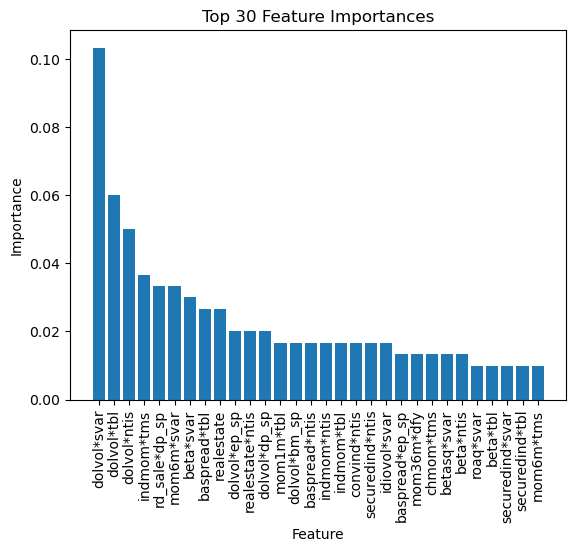

In [91]:
variable_importance(LGBM,30)

XGBoost

In [86]:
from xgboost import XGBRegressor

params = {
    'n_estimators': [500,600,800,1000],
    'max_depth': [1,2],
    'random_state': [12308],
    'learning_rate': [.01]
}
XGB = val_fun(XGBRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.50460%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 600, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.43554%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 800, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.33797%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 1000, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.02327%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 

In [87]:
evaluate(y_trn, XGB.predict(X_trn), insample=True)
evaluate(y_tst, XGB.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 10.04%
The in-sample MSE is 0.010
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 2.95%
The out-of-sample MSE is 0.008


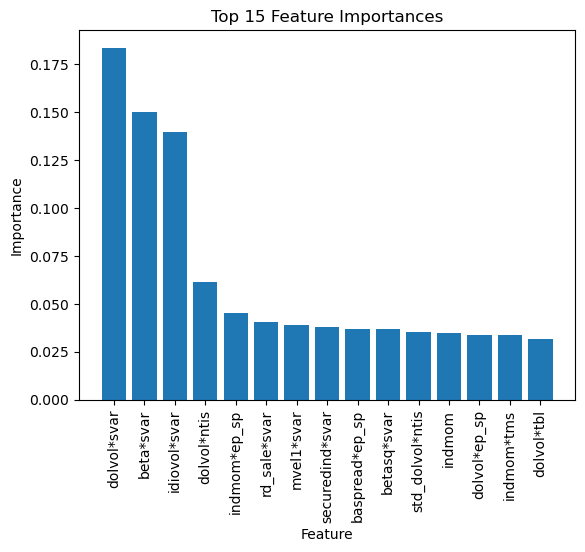

In [94]:
variable_importance(XGB,15)

Random Forest

In [99]:
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': [300],
    'max_depth': [3, 6],
    'max_features': [30, 50, 100],
    'random_state': [12308]
}
RF = val_fun(RandomForestRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'max_depth': 3, 'max_features': 30, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.00002%
************************************************************
Model with params: {'max_depth': 3, 'max_features': 50, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.19903%
************************************************************
Model with params: {'max_depth': 3, 'max_features': 100, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 1.41344%
************************************************************
Model with params: {'max_depth': 6, 'max_features': 30, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.02904%
************************************************************
Model with params: {'max_depth': 6, 'max_features': 50, 'n_estimators': 300, 'random_st

In [100]:
evaluate(y_trn, RF.predict(X_trn), insample=True)
evaluate(y_tst, RF.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 19.75%
The in-sample MSE is 0.009
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 2.75%
The out-of-sample MSE is 0.008


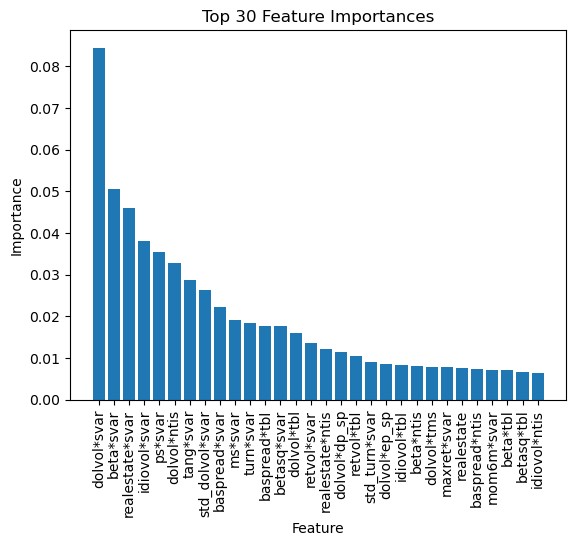

In [101]:
variable_importance(RF,30)

Neural Network

In [95]:
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization
from keras.regularizers import L1L2
from keras.optimizers import Adam

# customized metrics
# out-of-sample r squared for keras
def R_oos_tf(y_true, y_pred):
    resid = tf.square(y_true-y_pred)
    denom = tf.square(y_true)
    return 1 - tf.divide(tf.reduce_mean(resid),tf.reduce_mean(denom))

# data standardization
# please standardize the data if BatchNormalization is not used
def standardize(X_trn, X_vld, X_tst):
    mu_trn = np.mean(np.array(X_trn),axis=0).reshape((1,X_trn.shape[1]))
    sigma_trn = np.std(np.array(X_trn),axis=0).reshape((1,X_trn.shape[1]))

    X_trn_std = (np.array(X_trn)-mu_trn)/sigma_trn
    X_vld_std = (np.array(X_vld)-mu_trn)/sigma_trn
    X_tst_std = (np.array(X_tst)-mu_trn)/sigma_trn
    return X_trn_std, X_vld_std, X_tst_std

# NN class
class NN:

    def __init__(
        self, n_layers=1, loss='mse', l1=1e-5, l2=0, learning_rate=.01, BatchNormalization=True, patience=5,
        epochs=100, batch_size=3000, verbose=1, random_state=12308, monitor='val_R_oos_tf', base_neurons=5
    ):
        self.n_layers = n_layers
        self.l1 = l1
        self.l2 = l2
        self.learning_rate = learning_rate
        self.BatchNormalization = BatchNormalization
        self.patience = patience
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.random_state = random_state
        self.monitor = monitor
        self.base_neurons = base_neurons

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X_trn, y_trn, X_vld, y_vld):
        # fix random seed for reproducibility
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        tf.random.set_seed(self.random_state)

        # model construction
        mod = Sequential()
        mod.add(Input(shape=(X_trn.shape[1],)))

        for i in np.arange(self.n_layers,0,-1):
            if self.n_layers>self.base_neurons:
                if self.n_layers == i:
                    mod.add(Dense(2**i, activation='relu'))
                else:
                    mod.add(Dense(2**i, activation='relu', kernel_regularizer=L1L2(self.l1,self.l2)))
            else:
                if self.n_layers == i:
                    mod.add(Dense(2**(self.base_neurons-(self.n_layers-i)), activation='relu'))
                else:
                    mod.add(Dense(2**(self.base_neurons-(self.n_layers-i)),
                                  activation='relu', kernel_regularizer=L1L2(self.l1,self.l2)))
            if self.BatchNormalization:
                mod.add(BatchNormalization())

        mod.add(Dense(1, kernel_regularizer=L1L2(self.l1,self.l2)))

        # early stopping
        earlystop = tf.keras.callbacks.EarlyStopping(monitor=self.monitor, patience=self.patience)

        # Adam solver
        opt = Adam(learning_rate=self.learning_rate)

        # compile the model
        mod.compile(loss=self.loss,
                    optimizer=opt,
                    metrics=[R_oos_tf])

        # fit the model
        mod.fit(X_trn, np.array(y_trn).reshape((len(y_trn),1)), epochs=self.epochs, batch_size=self.batch_size,
                callbacks=[earlystop], verbose=self.verbose,
                validation_data=(X_vld,np.array(y_vld).reshape((len(y_vld),1))))

        self.model = mod
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=self.verbose)

In [96]:
# NN1-Regression-[32(relu)-1(linear)]

params = {
    'n_layers': [1],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN1 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

Model with params: {'BatchNormalization': True, 'batch_size': 1920, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -41.37628%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 1920, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_R_oos_tf', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: 0.01081%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 1920, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.01, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: 0.2166

In [97]:
evaluate(y_trn, NN1.predict(X_trn), insample=True)
evaluate(y_tst, NN1.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is -180.05%
The in-sample MSE is 0.032
***************Out-of-Sample Metrics***************
The out-of-sample R2 is -21.28%
The out-of-sample MSE is 0.010
